In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow
from keras.optimizers import Adam
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten,Conv1D,MaxPooling1D,RepeatVector
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler

In [2]:
df1 = pd.read_csv(r'D:\data_sets_git\pv_input_pvod.csv')
df1.Timestamp = pd.to_datetime(df1['date_time'])
df1.set_index('date_time',inplace=True)
df1.max()


#scaling
scaler = MinMaxScaler()
num_vars = ['lmd_totalirrad','lmd_temperature','lmd_pressure','lmd_winddirection','lmd_windspeed','power']
M = (df1.max())
m = (df1.min())
Ma=df1['power'].max()
ma=df1['power'].min()

df1[num_vars] = scaler.fit_transform(df1[num_vars])
M=np.array(M)
m=np.array(m)
M=np.reshape(M,(1,6))
m=np.reshape(m,(1,6))
k = df1.to_numpy()
df1= k


#devision of data
hours=100
window=700
ndf = df1[:-hours]
x_test = df1[-(hours+window):]
train_len = math.ceil(len(df1)*0.98)

# Training dataset generation
train_data = ndf[0:train_len]
X_train = []
Y_train = []
for i in range(window, len(train_data)-hours):
    X_train.append(train_data[i - window:i])
    Y_train.append(train_data[:,5][i:i+hours])

X_train, Y_train = np.array(X_train), np.array(Y_train)


# Validation dataset generation
val_data = ndf[train_len - window:]
X_val = []
Y_val = []
for i in range(window, len(val_data)-hours):
    X_val.append(val_data[i - window:i])
    Y_val.append(val_data[:,5][i:i+hours])

X_val, Y_val = np.array(X_val), np.array(Y_val)



print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

C:\Users\Z0172746\AppData\Local\Temp\ipykernel_12712\1286063794.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df1.Timestamp = pd.to_datetime(df1['date_time'])


(27519, 700, 6)
(27519, 100)
(377, 700, 6)
(377, 100)


In [3]:
def denorm(a):
    return a*(Ma-ma)+ma

In [4]:

model = Sequential()
model.add(Conv1D(filters =20, kernel_size=3, activation ='relu',input_shape=(700,6)))
model.add(Conv1D(filters=20, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=20, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=20, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=10, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=10, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=10, kernel_size=3, activation='relu'))

model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# model.add(RepeatVector(30))
# model.add(LSTM(50, return_sequences=True ,activation='relu', input_shape=(X_train.shape[1], 6), recurrent_dropout=0.2))
# model.add(LSTM(75, return_sequences=True, activation='relu'))
# model.add(LSTM(10, return_sequences=False, activation='relu'))
# model.add(Dense(100))
# model.add(Dropout(0.2))
# model.add(Dense(50))
# model.add(Dropout(0.2))
# model.add(Dense(150))
model.add(Dense(512))
model.add(Dense(100))
opt1 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=opt1, metrics = ['mae'])
model.fit(X_train, Y_train, epochs=150, batch_size=10, verbose=1)

Epoch 1/150
2752/2752 [==============================] - 41s 15ms/step - loss: 0.0139 - mae: 0.0659
Epoch 2/150
2752/2752 [==============================] - 41s 15ms/step - loss: 0.0057 - mae: 0.0500
Epoch 3/150
2752/2752 [==============================] - 41s 15ms/step - loss: 0.0043 - mae: 0.0442
Epoch 4/150
2752/2752 [==============================] - 38s 14ms/step - loss: 0.0036 - mae: 0.0407
Epoch 5/150
2752/2752 [==============================] - 45s 16ms/step - loss: 0.0031 - mae: 0.0380
Epoch 6/150
2752/2752 [==============================] - 49s 18ms/step - loss: 0.0028 - mae: 0.0360
Epoch 7/150
2752/2752 [==============================] - 47s 17ms/step - loss: 0.0025 - mae: 0.0343
Epoch 8/150
2752/2752 [==============================] - 47s 17ms/step - loss: 0.0024 - mae: 0.0330
Epoch 9/150
2752/2752 [==============================] - 45s 16ms/step - loss: 0.0022 - mae: 0.0320
Epoch 10/150
2752/2752 [==============================] - 45s 16ms/step - loss: 0.0022 - mae: 0.0315

In [5]:
# MAPE calculation
out_train= model.predict(X_train)
out_val=model.predict(X_val)

out_train = denorm(out_train)
out_val = denorm(out_val)

rr1=(np.round(np.sqrt(mean_squared_error(Y_train,out_train)),4))
rr2 = (np.round(np.sqrt(mean_squared_error(Y_val,out_val)), 4))
print('train error RMSE: ',rr1)
print('val error RMSE: ',rr2)

12/12 [==============================] - 0s 6ms/step
train error RMSE:  1.2494
val error RMSE:  1.3156


In [6]:
testData = x_test
X_test = testData[0:window]
Y_test = testData[:,5][window:]

X_test = np.reshape(X_test,(1,X_test.shape[0],X_test.shape[1]))
Y_test = np.reshape(Y_test,(1,Y_test.shape[0]))
out_test= model.predict(X_test)

rr3=(np.round(np.sqrt(mean_squared_error(denorm(Y_test),denorm(out_test))),4))
print('test error RMSE: ',rr3)

1/1 [==============================] - 0s 26ms/step
test error RMSE:  1.0417


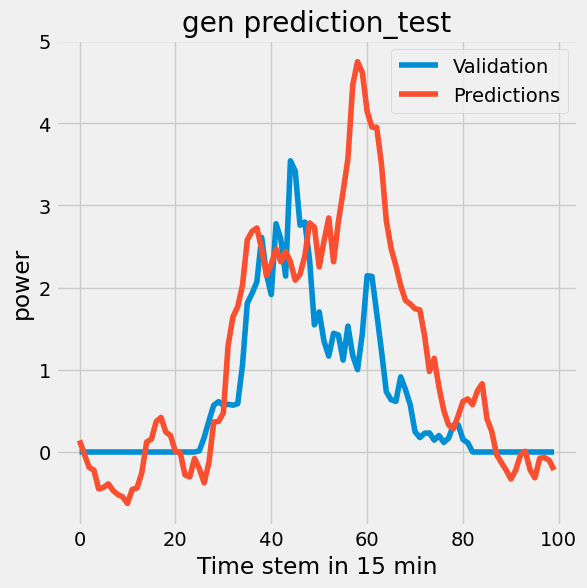

In [7]:
plt.figure(figsize=(6, 6))
plt.plot(denorm(Y_test.T))
plt.plot(denorm(out_test.T))
plt.title('gen prediction_test') 
plt.xlabel("Time stem in 15 min")
plt.ylabel("power")
plt.legend(['Validation', 'Predictions'])
plt.show()

In [8]:
Y_test = np.reshape(Y_test,(100,1))
out_test=np.reshape(out_test,(100,1))
out_test

array([[ 2.56228745e-02],
       [-4.32659686e-03],
       [-3.38404030e-02],
       [-3.97773087e-02],
       [-8.14311802e-02],
       [-7.80908763e-02],
       [-7.01346099e-02],
       [-8.48759562e-02],
       [-9.38305408e-02],
       [-9.88036096e-02],
       [-1.13466978e-01],
       [-8.23851675e-02],
       [-7.92397559e-02],
       [-4.53918874e-02],
       [ 2.18949467e-02],
       [ 2.84262151e-02],
       [ 6.71304613e-02],
       [ 7.61281624e-02],
       [ 4.40818742e-02],
       [ 3.60868573e-02],
       [ 6.83695078e-04],
       [-7.70211220e-04],
       [-5.05399406e-02],
       [-5.47817051e-02],
       [-1.42830461e-02],
       [-3.68270278e-02],
       [-6.81051165e-02],
       [-2.30099708e-02],
       [ 6.59705400e-02],
       [ 6.74079359e-02],
       [ 8.57669190e-02],
       [ 2.35102832e-01],
       [ 2.97479331e-01],
       [ 3.20219398e-01],
       [ 3.67354512e-01],
       [ 4.67381984e-01],
       [ 4.86244142e-01],
       [ 4.93586719e-01],
       [ 4.4